Import some stuff. We'll build our models with tensorflow2.

In [ ]:
import hub
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.__version__  #we used v2.9

We download the HASYv2 dataset from Hub|Activeloop.

In [2]:
help(hub.load)

Help on function load in module hub.api.dataset:

load(path: Union[str, pathlib.Path], read_only: Optional[bool] = None, memory_cache_size: int = 256, local_cache_size: int = 0, creds: Optional[dict] = None, token: Optional[str] = None, verbose: bool = True, access_method: str = 'stream') -> hub.core.dataset.dataset.Dataset
    Loads an existing dataset
    
    Args:
        path (str, pathlib.Path): - The full path to the dataset. Can be:
            - a Hub cloud path of the form `hub://username/datasetname`. To write to Hub cloud datasets, ensure that you are logged in to Hub (use 'activeloop login' from command line)
            - an s3 path of the form `s3://bucketname/path/to/dataset`. Credentials are required in either the environment or passed to the creds argument.
            - a local file system path of the form `./path/to/dataset` or `~/path/to/dataset` or `path/to/dataset`.
            - a memory path of the form `mem://path/to/dataset` which doesn't save the dataset but

In [9]:
#Specify where we want the download folder 
os.environ['HUB_DOWNLOAD_PATH'] = r"C:\datasets"
ds = {}
#We use block 1 to dowonload. Once downloaded the data can be loaded with block 2

#1

#ds[train] = hub.load("hub://activeloop/hasy-train", access_method='download')
#ds['test'] =  hub.load("hub://activeloop/hasy-test", access_method='download')

#2

ds['train'] = hub.load(r"C:\datasets\hub_activeloop_hasy-train")
ds['test'] = hub.load(r"C:\datasets\hub_activeloop_hasy-test")

C:\datasets\hub_activeloop_hasy-train loaded successfully.
C:\datasets\hub_activeloop_hasy-test loaded successfully.


Let's explore what we have actually downloaded.

In [10]:
type(ds['train'])

hub.core.dataset.dataset.Dataset

The dataset has the type 'hub.core.dataset.dataset.Dataset'. We use 

In [ ]:
help(hub.core.dataset.dataset)

to explore this class. We find the function summary.

In [11]:
ds['train'].summary()

Dataset(path='C:\datasets\hub_activeloop_hasy-train', tensors=['images', 'latex'])

 tensor      htype            shape          dtype  compression
 -------    -------          -------        -------  ------- 
 images      image     (151241, 32, 32, 3)   uint8    jpeg   
  latex   class_label      (151241, 1)      uint32    None   


The dataset contains x = images (32x32 pixels with 3 color channels) and y = integer labels. Note that y is is is a 2D-tensor of dimension (151241, 1) not (151241, ), i.e., the ineger labels are safed in an extra pocketdimension. 

In [15]:
x_raw = {}
y_raw = {}
for a in ['test', 'train']:
    x_raw[a] = ds[a].tensors['images'].data()['value']
    y_raw[a] = ds[a].tensors['latex'].data()['value']

Let us explore what the integer labels actually stand for.

In [21]:
class_names = ds['train'].tensors['latex'].info['class_names']
#We change the label # to hash to avoid problems caused by certain csv-editors
class_names[123] = 'hash' 

num_labels = len(class_names)
print(num_labels)
print(class_names)

364
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'rightarrow', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'pi', 'alpha', 'beta', 'sum', 'sigma', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'x', 'y', 'z', 'Sigma', 'gamma', 'Gamma', 'delta', 'Delta', 'zeta', 'eta', 'theta', 'Theta', 'epsilon', 'varepsilon', 'iota', 'kappa', 'varkappa', 'lambda', 'Lambda', 'mu', 'nu', 'xi', 'Xi', 'Pi', 'rho', 'varrho', 'tau', 'phi', 'Phi', 'varphi', 'chi', 'psi', 'Psi', 'omega', 'Omega', 'partial', 'int', 'cdot', 'leq', 'geq', '<', '>', 'subset', 'supset', 'subseteq', 'supseteq', 'cong', 'propto', '-', '+', 'mathbb{R}', '$', '{', 'copyright', 'dots', '}', 'dag', 'pounds', '&', 'hash', '%', 'checkmark', 'circledR', 'mathsection', 'amalg', 'cup', 'oplus', 'times', 'ast', 'triangleleft', 'otimes', 'triangleright', 'diamond', 'pm', 'div', 'bullet', 'set

We notice that there are 364 classes of latex symbols. Having our application in mind it seems reasonable to remove symbols that are rarely-never used or have a very similar or identical alternative. For example: Sigma and sum are the same Symbol. You need the context to understand which one it is. We did this manually by generating a csv file and labeling the symbols we want to keep. 

In [65]:
#   with open('hasy_clean.csv', 'w') as f:
#       for cn in class_names:
#           f.write(cn+'\n')

With the csv prepared, we define a map that associates a class_name to its new index or -1 if it shall be deleted. We also define an inverse map.

In [22]:
#'hasy_clean.csv' is a two collumn csv file, the first collumn contains the classnames, 
# the second y if we want to keept it and n if we don't 

map_cn_to_keep = {}
with open('hasy_clean.csv', 'r') as f:
    for line in f.readlines():
        cn, keep = line.strip('\n').split(sep=',')
        if keep == 'y':
            map_cn_to_keep[cn] = True
        if keep == 'n':
            map_cn_to_keep[cn] = False

#the following dictionary maps class_names to their new index, -1 means deleting it
i = 0
map_cn_to_new_index = {}
map_new_index_to_cn = {-1: []}
for cn in class_names:
    if map_cn_to_keep[cn]:
        map_cn_to_new_index[cn] = i
        i+=1
        map_new_index_to_cn[i] = cn
    else:
        map_cn_to_new_index[cn] = -1
        map_new_index_to_cn[-1].append(cn)

num_labels = i+1
num_labels

261

Now we can clean the raw data tensors.

In [23]:
x = {}
y = {}
for a in ['train','test']:
    #the x_raw data has 3 color channels, we convert to grayscale.
    x_ = tf.image.rgb_to_grayscale(tf.convert_to_tensor(x_raw[a]))
    #the y_raw integer labels sit in a pocket dimension. We squeeze it.
    y_ = tf.squeeze(tf.convert_to_tensor(y_raw[a]), axis =-1)

    x_list = []
    y_list = []

    for i,label in enumerate(y_):
        if map_cn_to_new_index[class_names[label]] != -1:
            x_list.append(x_[i])
            y_list.append(map_cn_to_new_index[class_names[label]])

    x[a] = tf.convert_to_tensor(x_list)
    y[a] = tf.convert_to_tensor(y_list)       
    #normalize training images
    x[a] = x[a] / 255

In [69]:
y['class names'] = [map_new_index_to_cn[i] for i in map_new_index_to_cn if i != -1]
y['num labels'] = len(y['class names'])

Next we do a 4:1 training:validation split for the training data.

In [28]:
if 'val' in x:
    print('already splited')
else:
    #shuffel x and y tensors the same way
    indices = tf.range(start=0,limit=tf.shape(x['train'])[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)
    x_ = tf.gather(x['train'], shuffled_indices)
    y_ = tf.gather(y['train'], shuffled_indices)

    #split 4:1
    n = len(x['train'])
    x['val'] = x_[n*4//5::]
    y['val'] = y_[n*4//5::]
    x['train'] = x_[:n*4//5:]
    y['train'] = y_[:n*4//5:]

already splited


Now that the data is prepared let's have a look at some of the images.

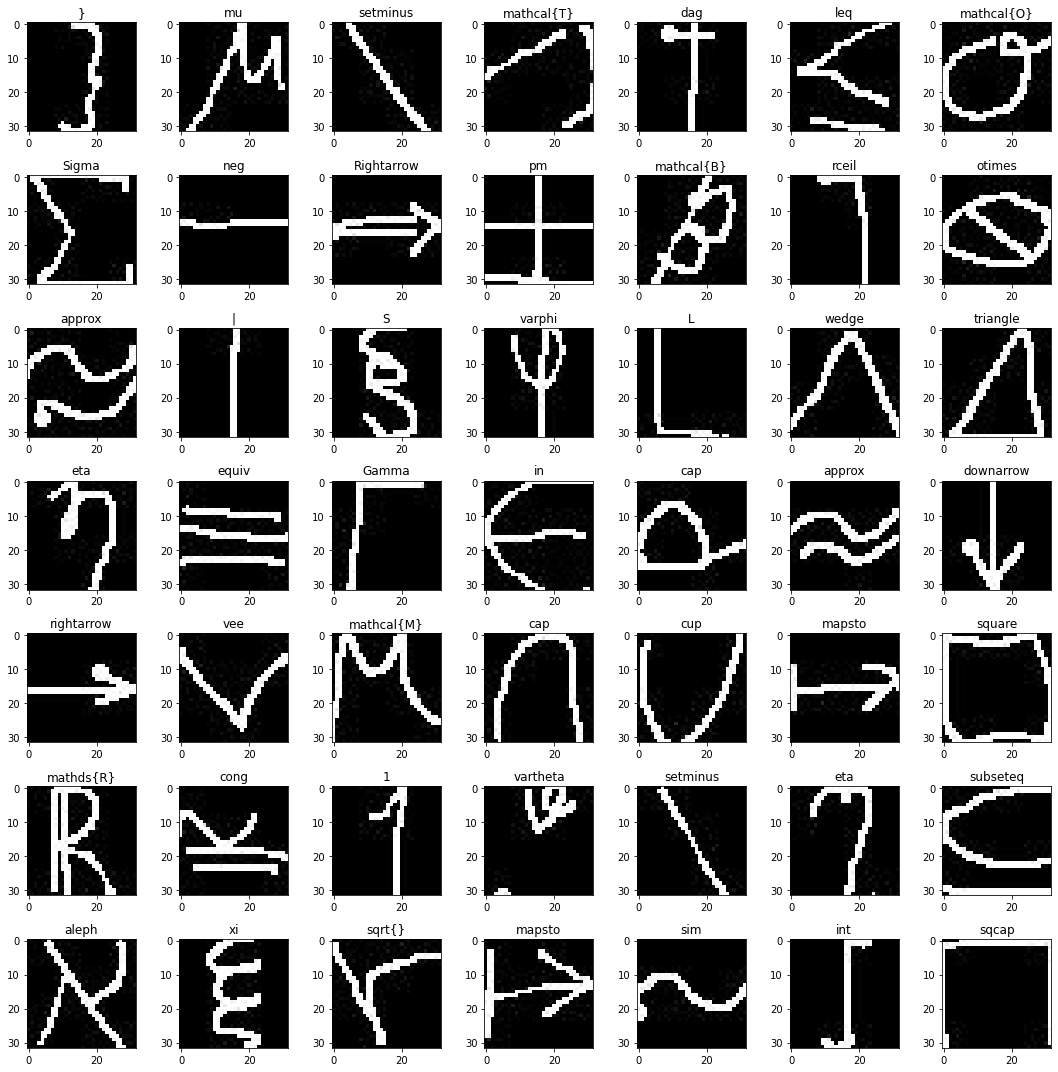

In [67]:
fig = plt.figure(figsize=(15,15))
for i in range(1,50):
    ax = fig.add_subplot(7,7,i)
    plt.imshow(x['train'][i], cmap=plt.cm.binary)
    ax.set_title(y['class names'][y['train'][i]])
fig.tight_layout()

I looked at a few batches of 49 images and had truble identifying about 4-5 images per batch. So lets set 80% as the goal for our OCR-Models. Our first Model is the very naive approach of flattening + fully connected layers. We add some Dropout layer to hopefully prevent overfitting.

In [81]:
n = y['num labels'] # =260 for our choice of charachters

def build_naive_model(hidden_layer_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(32,32,1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(hidden_layer_size),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(n)
    ])

    # I find the word sparse in the name of the loss function very confusing. So let me explain. 
    # The labels are encoded as integers so we use SparseCategoricalCrossentropy as loss, for one-hot encoding use CategoricalCrossentropy.

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss= loss_fn, metrics=['accuracy'])

    return model

# We experiment with three sizes for the hidden layer sizes. Choizes between n = 261 and 1024 seen sensible.

naive_models = [build_naive_model(s) for s in [300,500,700]]

naive_models[0].summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 1024)              0         
                                                                 
 dropout_41 (Dropout)        (None, 1024)              0         
                                                                 
 dense_40 (Dense)            (None, 300)               307500    
                                                                 
 dropout_42 (Dropout)        (None, 300)               0         
                                                                 
 dense_41 (Dense)            (None, 260)               78260     
                                                                 
Total params: 385,760
Trainable params: 385,760
Non-trainable params: 0
_________________________________________________________________


In [82]:
histories_naive = [m.fit(x['train'], y['train'], epochs=5, validation_data=(x['val'],y['val'])) for m in naive_models]

Epoch 1/5
2936/2936 [==============================] - 12s 4ms/step - loss: 2.7530 - accuracy: 0.4260 - val_loss: 1.9078 - val_accuracy: 0.5807
Epoch 2/5
2936/2936 [==============================] - 13s 4ms/step - loss: 2.2936 - accuracy: 0.5025 - val_loss: 1.7909 - val_accuracy: 0.5966
Epoch 3/5
2936/2936 [==============================] - 13s 4ms/step - loss: 2.2467 - accuracy: 0.5103 - val_loss: 1.8586 - val_accuracy: 0.5870
Epoch 4/5
2936/2936 [==============================] - 13s 4ms/step - loss: 2.2456 - accuracy: 0.5104 - val_loss: 1.8994 - val_accuracy: 0.5752
Epoch 5/5
2936/2936 [==============================] - 14s 5ms/step - loss: 2.2428 - accuracy: 0.5107 - val_loss: 1.9644 - val_accuracy: 0.5711
Epoch 1/5
2936/2936 [==============================] - 21s 7ms/step - loss: 2.9070 - accuracy: 0.4165 - val_loss: 2.0411 - val_accuracy: 0.5599
Epoch 2/5
2936/2936 [==============================] - 21s 7ms/step - loss: 2.5013 - accuracy: 0.4836 - val_loss: 2.0442 - val_accuracy:

All naive models have a valuation accurazy of about 55%. Let's see if we can do better with CNNs.

In [87]:
def build_cnn_model(conv_layer_filter_sizes, hidden_fc_layer_size):
    model = tf.keras.Sequential()
    for i,s in enumerate(conv_layer_filter_sizes):
        if i == 0:
            model.add(tf.keras.layers.Conv2D(filters = s, kernel_size=(3,3), input_shape=(32,32,1),activation = 'relu'))
        else:
            model.add(tf.keras.layers.Conv2D(filters = s, kernel_size=(3,3), input_shape=(None,None,1),activation = 'relu'))
        model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(hidden_fc_layer_size,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(261))
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss= loss_fn, metrics=['accuracy'])

    return model

sizes = [[[16,32],300], [[32,64],500],[[50,100],700]]    

cnn_models = [build_cnn_model(s[0],s[1]) for s in sizes]

cnn_models[0].summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_28 (Flatten)        (None, 1152)              0         
                                                                 
 dropout_55 (Dropout)        (None, 1152)            

In [88]:
histories_cnn = [m.fit(x['train'], y['train'], epochs=5, validation_data=(x['val'],y['val'])) for m in cnn_models]

Epoch 1/5
2936/2936 [==============================] - 45s 15ms/step - loss: 1.6174 - accuracy: 0.6258 - val_loss: 0.8507 - val_accuracy: 0.7789
Epoch 2/5
2936/2936 [==============================] - 51s 17ms/step - loss: 0.8782 - accuracy: 0.7674 - val_loss: 0.7128 - val_accuracy: 0.8121
Epoch 3/5
2936/2936 [==============================] - 53s 18ms/step - loss: 0.7560 - accuracy: 0.7937 - val_loss: 0.6595 - val_accuracy: 0.8230
Epoch 4/5
2936/2936 [==============================] - 53s 18ms/step - loss: 0.6813 - accuracy: 0.8104 - val_loss: 0.6301 - val_accuracy: 0.8302
Epoch 5/5
2936/2936 [==============================] - 53s 18ms/step - loss: 0.6301 - accuracy: 0.8206 - val_loss: 0.6128 - val_accuracy: 0.8377
Epoch 1/5
2936/2936 [==============================] - 106s 36ms/step - loss: 1.3550 - accuracy: 0.6798 - val_loss: 0.7474 - val_accuracy: 0.8053
Epoch 2/5
2936/2936 [==============================] - 105s 36ms/step - loss: 0.7347 - accuracy: 0.7999 - val_loss: 0.6422 - val_

Seems like Cnn's perform with about 80-84% accuracy, so about as good as I did. Also note that the loss is much smaller than in the naive aproach. That means even if the first quess is not right, often the seccond or third is. Giving the model more parameters to work with seems to not help significantly. It gives the model more room to overfit. 

Now let's evaluate the models. The way we build them, all models output logits.

In [96]:
m = cnn_models[0]
m.save('saved_models/hasy_conv_2')

INFO:tensorflow:Assets written to: saved_models/hasy_conv_2\assets


INFO:tensorflow:Assets written to: saved_models/hasy_conv_2\assets


In [185]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [186]:
predictions = probability_model.predict(x_train)


2936/2936 [==============================] - 33s 11ms/step


In [187]:
new_class_names = [map_new_index_to_cn[i] for i in map_new_index_to_cn if i != -1]

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(new_class_names[predicted_label],
                                100*np.max(predictions_array),
                                new_class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(261))
  plt.yticks([])
  thisplot = plt.bar(range(261), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


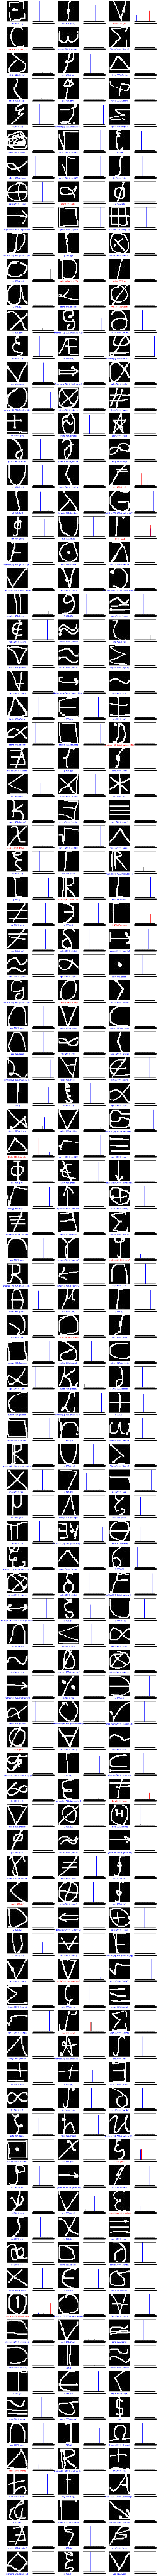

In [189]:
num_rows = 100
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_train, x_train)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_train)
plt.tight_layout()
plt.show()


In [143]:
# The train images come in rgb format have the data safed in a pocket dimension. 
# We convert to grayscale and remove the extra dimension.

x_train_ = tf.image.rgb_to_grayscale(tf.convert_to_tensor(x_train_raw))
y_train_ = tf.squeeze(tf.convert_to_tensor(y_train_raw), axis =-1)

x_train = []
y_train = []

for i,y  in enumerate(y_train_):
    if map_cn_to_new_index[class_names[y]] != -1:
        x_train.append(x_train_[i])
        y_train.append(map_cn_to_new_index[class_names[y]])

x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)       
#normalize training images
x_train = x_train / 255

In [147]:
indices = tf.range(start=0,limit=tf.shape(x_train)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

x_train = tf.gather(x_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)
num_train = len(x_train)

x_val = x_train[num_train*4//5::]
x_train = x_train[:num_train*4//5:]
y_val= y_train[num_train*4//5::]
y_train= y_train[:num_train*4//5:]

In [183]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), input_shape=(32,32,1), activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), input_shape=(None,None,1), activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(input_shape=(None,None,None)),
    tf.keras.layers.Dense(500,activation='relu'),
    tf.keras.layers.Dense(261)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss= loss_fn, metrics=['accuracy'])

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 2304)              0         
                                                                 
 dense_21 (Dense)            (None, 500)             

In [184]:
model.fit(x_train, y_train, epochs=5, validation_data=(x_val,y_val))

Epoch 1/5
2936/2936 [==============================] - 95s 32ms/step - loss: 1.2189 - accuracy: 0.7104 - val_loss: 0.7318 - val_accuracy: 0.8066
Epoch 2/5
2936/2936 [==============================] - 108s 37ms/step - loss: 0.6323 - accuracy: 0.8262 - val_loss: 0.6475 - val_accuracy: 0.8244
Epoch 3/5
2936/2936 [==============================] - 110s 37ms/step - loss: 0.4986 - accuracy: 0.8542 - val_loss: 0.6269 - val_accuracy: 0.8317
Epoch 4/5
2936/2936 [==============================] - 113s 38ms/step - loss: 0.3988 - accuracy: 0.8770 - val_loss: 0.6351 - val_accuracy: 0.8344
Epoch 5/5
2936/2936 [==============================] - 114s 39ms/step - loss: 0.3144 - accuracy: 0.8973 - val_loss: 0.6903 - val_accuracy: 0.8331


In [191]:
!mkdir -p saved_models
model.save('saved_models/hasy_conv')


Ein Unterverzeichnis oder eine Datei mit dem Namen "-p" existiert bereits.
Folgender Fehler trat auf: -p.
Ein Unterverzeichnis oder eine Datei mit dem Namen "saved_models" existiert bereits.
Folgender Fehler trat auf: saved_models.


INFO:tensorflow:Assets written to: saved_models/hasy_conv\assets


INFO:tensorflow:Assets written to: saved_models/hasy_conv\assets
